In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np

# Fetch dataset 
adult = fetch_ucirepo(id=2) 

# Data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

# 1. First filter missing values from features
columns_to_check = ['workclass', 'native-country', 'occupation']
mask = (~X[columns_to_check].isin(['?']) & ~X[columns_to_check].isna()).all(axis=1)
filtered_X = X[mask].copy()
filtered_y = y[mask].copy()

# 2. Then clean the income column in the filtered data
filtered_y['income'] = filtered_y['income'].str.rstrip('.')

Text(0, 0.5, 'Count')

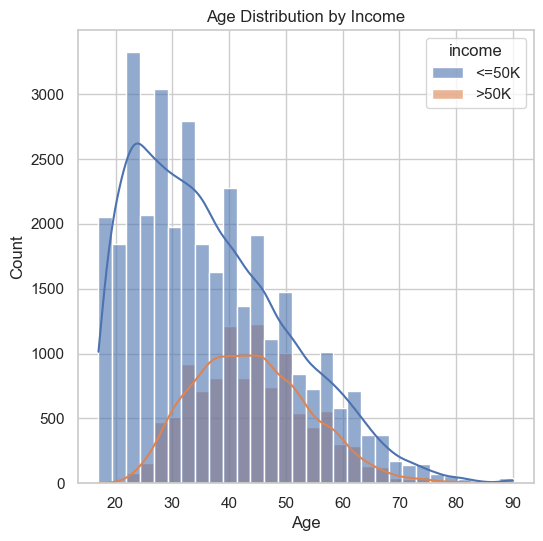

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better-looking plots
sns.set(style="whitegrid")
plt.figure(figsize=(20, 20))

# 1. Age distribution by income
plt.subplot(3, 3, 1)
sns.histplot(data=filtered_X.join(filtered_y), x='age', hue='income', bins=30, kde=True, alpha=0.6)
plt.title('Age Distribution by Income')
plt.xlabel('Age')
plt.ylabel('Count')

Results Summary:

True Counts by Age Group and Income:
  Age Group Income  True Count
0     51-60  <=50K      3664.0
1     51-60   >50K      2169.0
2       >60  <=50K      2138.0
3       >60   >50K       710.0
4       ≤50  <=50K     28212.0
5       ≤50   >50K      8329.0

Privacy Results by Epsilon:
        Age Group Income Absolute Error                         Runtime (ms)  \
Epsilon                           0.001   0.01   0.1   0.5  1.0        0.001   
0           51-60  <=50K         1479.0  148.0   6.0   7.0  0.0       0.0005   
1           51-60   >50K          433.0  102.0  12.0   3.0  1.0       0.0005   
2             >60  <=50K          423.0    3.0   2.0   1.0  0.0       0.0005   
3             >60   >50K          556.0   82.0   2.0   3.0  0.0       0.0004   
4             ≤50  <=50K          289.0  167.0  12.0   0.0  0.0       0.0005   
5             ≤50   >50K           88.0   29.0  17.0  15.0  0.0       0.0005   

                                         
Epsilon    0.01 

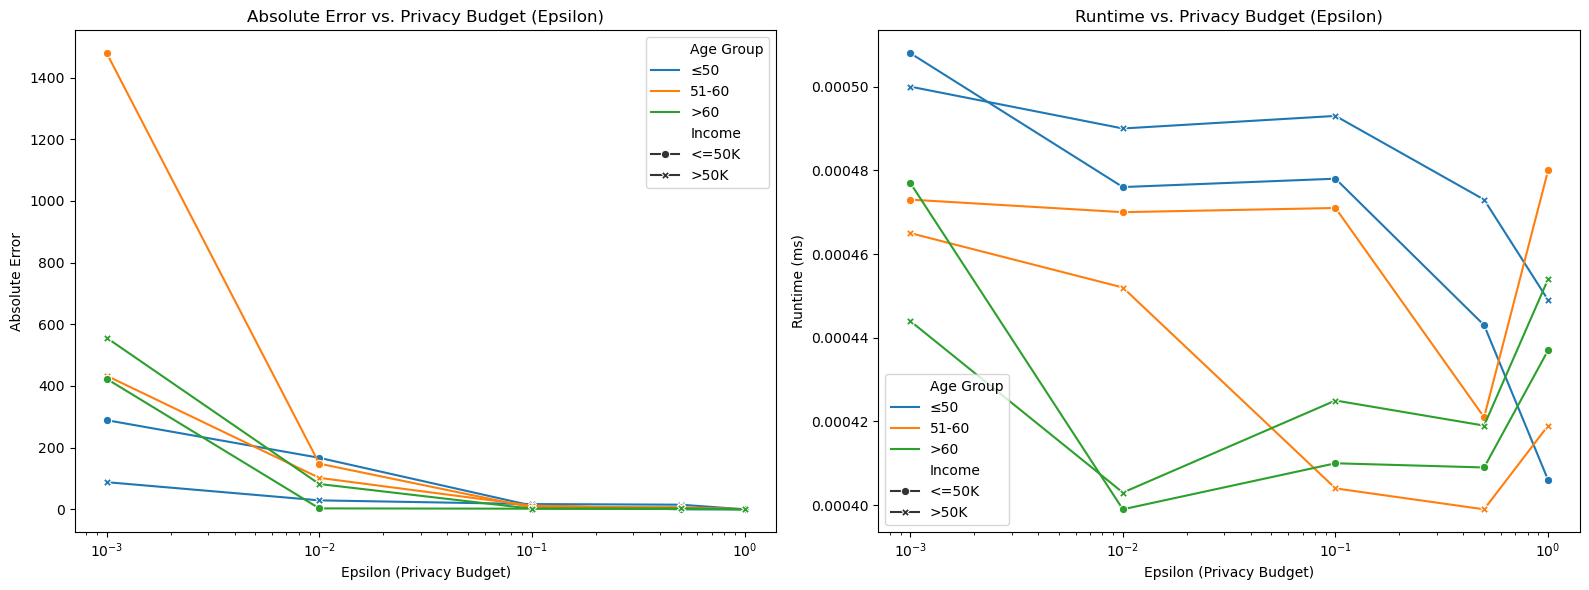

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Create a combined DataFrame for easier analysis
combined_df = pd.concat([filtered_X, filtered_y], axis=1)

# Define age groups
def assign_age_group(age):
    if age <= 50:
        return "≤50"
    elif age <= 60:
        return "51-60"
    else:
        return ">60"

# Add age group column
combined_df['age_group'] = combined_df['age'].apply(assign_age_group)

# Define privacy budgets
epsilon_values = [0.001, 0.01, 0.1, 0.5, 1]

# Laplace mechanism for differential privacy
def laplace_mechanism(count, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return max(0, int(round(count + noise)))

# Measure runtime
def measure_runtime(func, count, epsilon, num_iterations=1000):
    start_time = time.time()
    for _ in range(num_iterations):
        func(count, epsilon)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Calculate results
results = []
np.random.seed(42)
age_groups = ["≤50", "51-60", ">60"]
income_categories = ["<=50K", ">50K"]

for age_group in age_groups:
    subset = combined_df[combined_df['age_group'] == age_group]
    
    for epsilon in epsilon_values:
        for income in income_categories:
            true_count = len(subset[subset['income'] == income])
            dp_count = laplace_mechanism(true_count, epsilon)
            runtime = measure_runtime(laplace_mechanism, true_count, epsilon)
            abs_error = abs(true_count - dp_count)
            
            results.append({
                'Age Group': age_group,
                'Epsilon': epsilon,
                'Income': income,
                'True Count': true_count,
                'Absolute Error': abs_error,
                'Runtime (ms)': round(runtime, 6)
            })

results_df = pd.DataFrame(results)

# Print out summary of results
print("Results Summary:")
# First create a DataFrame with just the true counts (they're the same for all epsilon values)
true_counts_df = results_df[['Age Group', 'Income', 'True Count']].drop_duplicates()
print("\nTrue Counts by Age Group and Income:")
print(true_counts_df.pivot_table(index=['Age Group', 'Income'], values='True Count').reset_index())

# Then show the privacy results by epsilon
summary_df = results_df.pivot_table(
    index=['Age Group', 'Income'], 
    columns=['Epsilon'], 
    values=['Absolute Error', 'Runtime (ms)']
).reset_index()
print("\nPrivacy Results by Epsilon:")
print(summary_df.round(4))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error - Line plot with markers
sns.lineplot(x='Epsilon', y='Absolute Error', hue='Age Group', style='Income', 
             markers=True, dashes=False, data=results_df, ax=ax1)
ax1.set_title('Absolute Error vs. Privacy Budget (Epsilon)')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale makes the epsilon values more evenly spaced

# Plot 2: Runtime - Line plot with markers
sns.lineplot(x='Epsilon', y='Runtime (ms)', hue='Age Group', style='Income', 
             markers=True, dashes=False, data=results_df, ax=ax2)
ax2.set_title('Runtime vs. Privacy Budget (Epsilon)')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

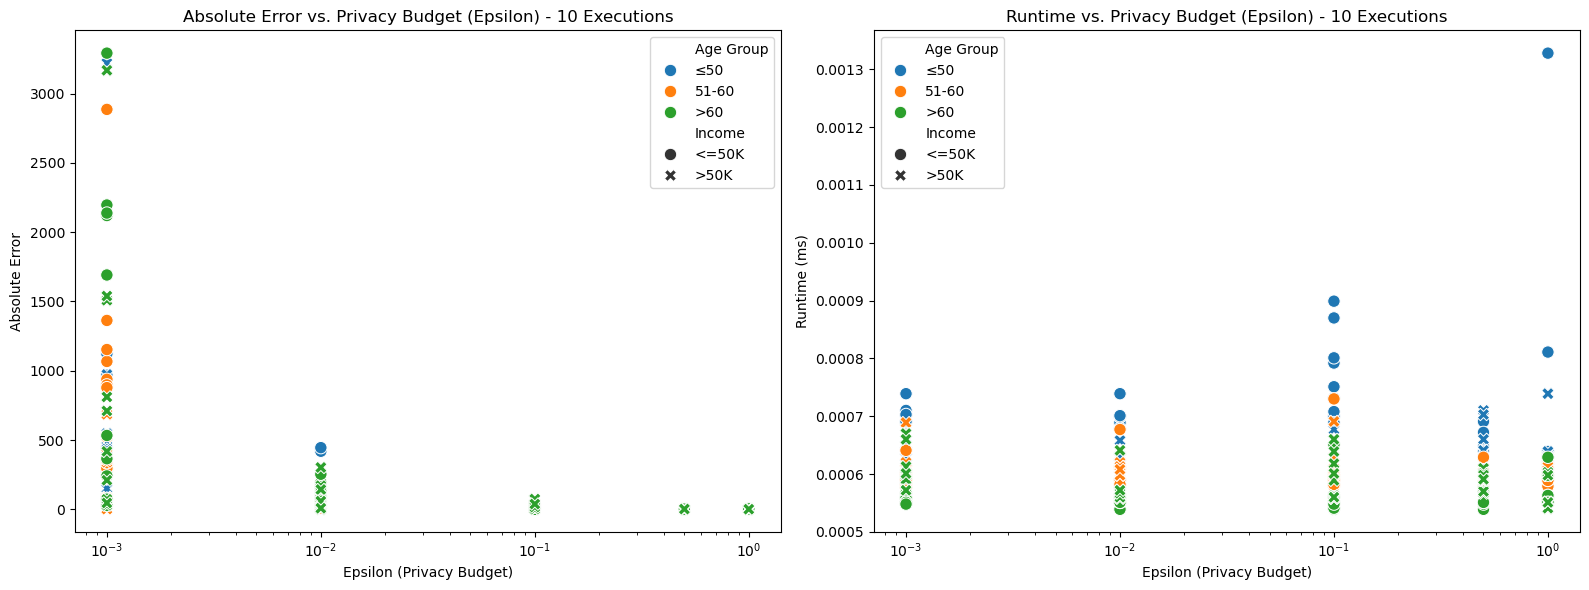

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Laplace mechanism for differential privacy
def laplace_mechanism(count, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return max(0, int(round(count + noise)))

# Measure runtime
def measure_runtime(func, count, epsilon, num_iterations=100):
    start_time = time.time()
    for _ in range(num_iterations):
        func(count, epsilon)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Define privacy budgets
epsilon_values = [0.001, 0.01, 0.1, 0.5, 1]
num_executions = 10

# Calculate results for multiple executions
results = []
np.random.seed(42)
age_groups = ["≤50", "51-60", ">60"]
income_categories = ["<=50K", ">50K"]

for age_group in age_groups:
    subset = combined_df[combined_df['age_group'] == age_group]
    
    for income in income_categories:
        true_count = len(subset[subset['income'] == income])
        
        for epsilon in epsilon_values:
            # Run 10 independent executions
            for execution in range(num_executions):
                dp_count = laplace_mechanism(true_count, epsilon)
                runtime = measure_runtime(laplace_mechanism, true_count, epsilon)
                abs_error = abs(true_count - dp_count)
                
                results.append({
                    'Age Group': age_group,
                    'Epsilon': epsilon,
                    'Income': income,
                    'True Count': true_count,
                    'DP Count': dp_count,
                    'Absolute Error': abs_error,
                    'Runtime (ms)': round(runtime, 6),
                    'Execution': execution + 1
                })

results_df = pd.DataFrame(results)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Absolute Error', hue='Age Group', style='Income',
             data=results_df, s=80, ax=ax1)  # s controls the dot size

ax1.set_title('Absolute Error vs. Privacy Budget (Epsilon) - 10 Executions')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale for epsilon values

# Plot 2: Runtime vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Runtime (ms)', hue='Age Group', style='Income',
             data=results_df, s=80, ax=ax2)  # s controls the dot size

ax2.set_title('Runtime vs. Privacy Budget (Epsilon) - 10 Executions')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')  # Log scale for epsilon values

plt.tight_layout()
plt.show()

Results Summary:

True Counts by Age Group and Income:
  Age Group Income  True Count
0     51-60  <=50K      3664.0
1     51-60   >50K      2169.0
2       >60  <=50K      2138.0
3       >60   >50K       710.0
4       ≤50  <=50K     28212.0
5       ≤50   >50K      8329.0

Privacy Results by Epsilon:
        Age Group Income Absolute Error                                \
Epsilon                           0.001       0.01       0.1      0.5   
0           51-60  <=50K      3733295.0   359347.0   35401.0   5747.0   
1           51-60   >50K      2096789.0   221041.0   20062.0   3245.0   
2             >60  <=50K      2192574.0   214376.0   21233.0   3127.0   
3             >60   >50K       654002.0    69003.0    5847.0   1264.0   
4             ≤50  <=50K     28532426.0  2814097.0  266216.0  43547.0   
5             ≤50   >50K      7990307.0   821763.0   81228.0  12781.0   

                 Runtime (ms)                                  
Epsilon      1.0        0.001    0.01     0.1     

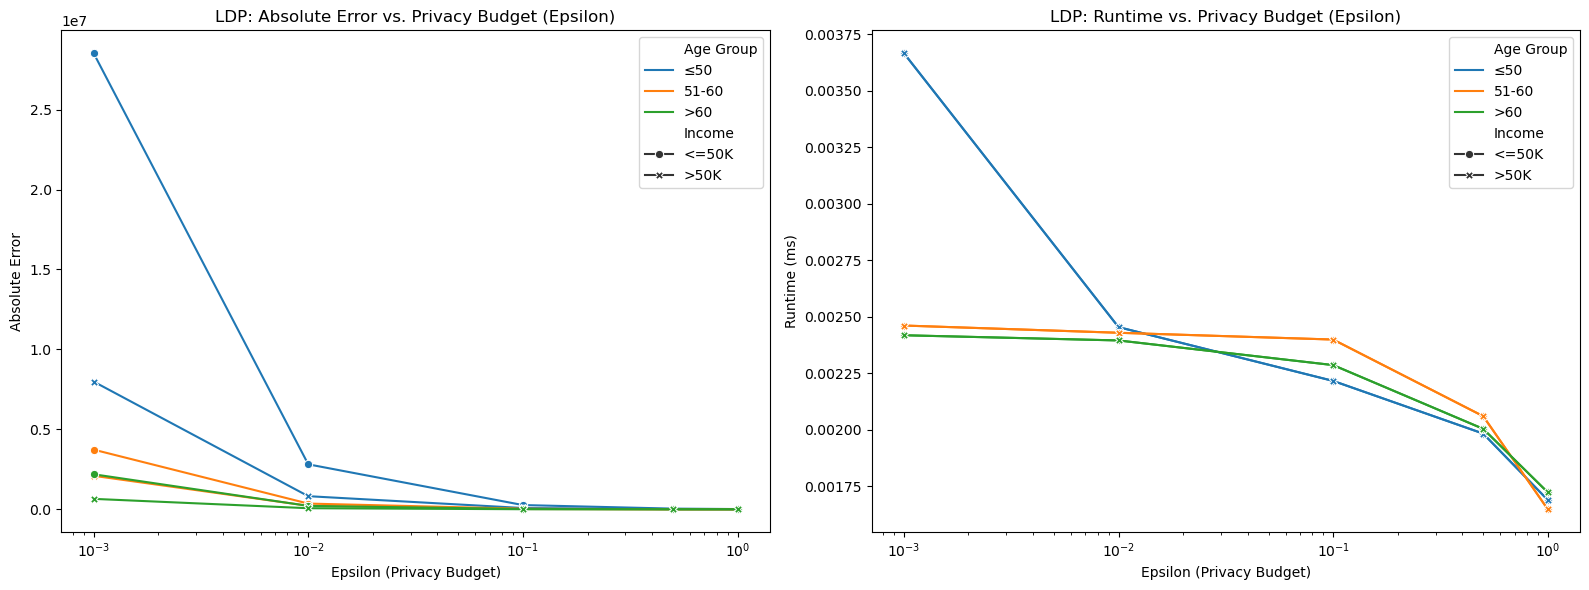

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Define epsilon values for Local Differential Privacy
epsilon_values_ldp = [0.001, 0.01,0.1, 0.5, 1.0]

# Randomized Response mechanism for Local Differential Privacy
def randomized_response(value, epsilon, domain=["<=50K", ">50K"]):
    """
    Implements randomized response for Local Differential Privacy.
    
    Args:
        value: True value
        epsilon: Privacy parameter
        domain: Possible values
    
    Returns:
        Privatized value
    """
    # Calculate probability of keeping true value
    p = np.exp(epsilon) / (1 + np.exp(epsilon))
    
    # With probability p, keep the true value
    # With probability 1-p, sample uniformly from the domain
    if np.random.random() < p:
        return value
    else:
        return np.random.choice(domain)

# Function to measure runtime
def measure_ldp_runtime(func, value, epsilon, domain, num_iterations=1000):
    start_time = time.time()
    for _ in range(num_iterations):
        func(value, epsilon, domain)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Calculate results for LDP
ldp_results = []
np.random.seed(42)  # Set seed for reproducibility
age_groups = ["≤50", "51-60", ">60"]
income_categories = ["<=50K", ">50K"]

for age_group in age_groups:
    # Get subset of data for this age group
    subset = combined_df[combined_df['age_group'] == age_group]
    total_records = len(subset)
    
    for epsilon in epsilon_values_ldp:
        # Measure average runtime
        sample_income = income_categories[0]
        runtime = measure_ldp_runtime(randomized_response, sample_income, epsilon, income_categories)
        
        # Apply randomized response to each individual
        privatized_incomes = []
        for _, row in subset.iterrows():
            privatized_income = randomized_response(row['income'], epsilon, income_categories)
            privatized_incomes.append(privatized_income)
        
        for income in income_categories:
            # Get true count for this income category in this age group
            true_count = len(subset[subset['income'] == income])
            
            # Count of privatized responses for this income category
            privatized_count = privatized_incomes.count(income)
            
            # Calculate corrected estimate using the proper formula for binary randomized response
            p = np.exp(epsilon) / (1 + np.exp(epsilon))
            corrected_estimate = (privatized_count - total_records*(1-p)/2) / (2*p - 1)
            corrected_estimate = int(round(corrected_estimate))
            
            # Ensure the corrected estimate is non-negative
            corrected_estimate = max(0, corrected_estimate)
            
            # Calculate error metrics
            abs_error = abs(true_count - corrected_estimate)
            
            ldp_results.append({
                'Age Group': age_group,
                'Epsilon': epsilon,
                'Income': income,
                'True Count': true_count,
                'LDP Count': privatized_count,
                'Corrected Estimate': corrected_estimate,
                'Absolute Error': abs_error,
                'Runtime (ms)': round(runtime, 6)
            })

ldp_results_df = pd.DataFrame(ldp_results)

# Print out summary of results
print("Results Summary:")

# First create a DataFrame with just the true counts (they're the same for all epsilon values)
true_counts_df = ldp_results_df[['Age Group', 'Income', 'True Count']].drop_duplicates()
print("\nTrue Counts by Age Group and Income:")
print(true_counts_df.pivot_table(index=['Age Group', 'Income'], values='True Count').reset_index())

# Then show the privacy results by epsilon
summary_df = ldp_results_df.pivot_table(
    index=['Age Group', 'Income'], 
    columns=['Epsilon'], 
    values=['Absolute Error', 'Runtime (ms)']
).reset_index()

print("\nPrivacy Results by Epsilon:")
print(summary_df.round(4))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error - Line plot with markers
sns.lineplot(x='Epsilon', y='Absolute Error', hue='Age Group', style='Income', 
             markers=True, dashes=False, data=ldp_results_df, ax=ax1)
ax1.set_title('LDP: Absolute Error vs. Privacy Budget (Epsilon)')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale makes the epsilon values more evenly spaced

# Plot 2: Runtime - Line plot with markers
sns.lineplot(x='Epsilon', y='Runtime (ms)', hue='Age Group', style='Income', 
             markers=True, dashes=False, data=ldp_results_df, ax=ax2)
ax2.set_title('LDP: Runtime vs. Privacy Budget (Epsilon)')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

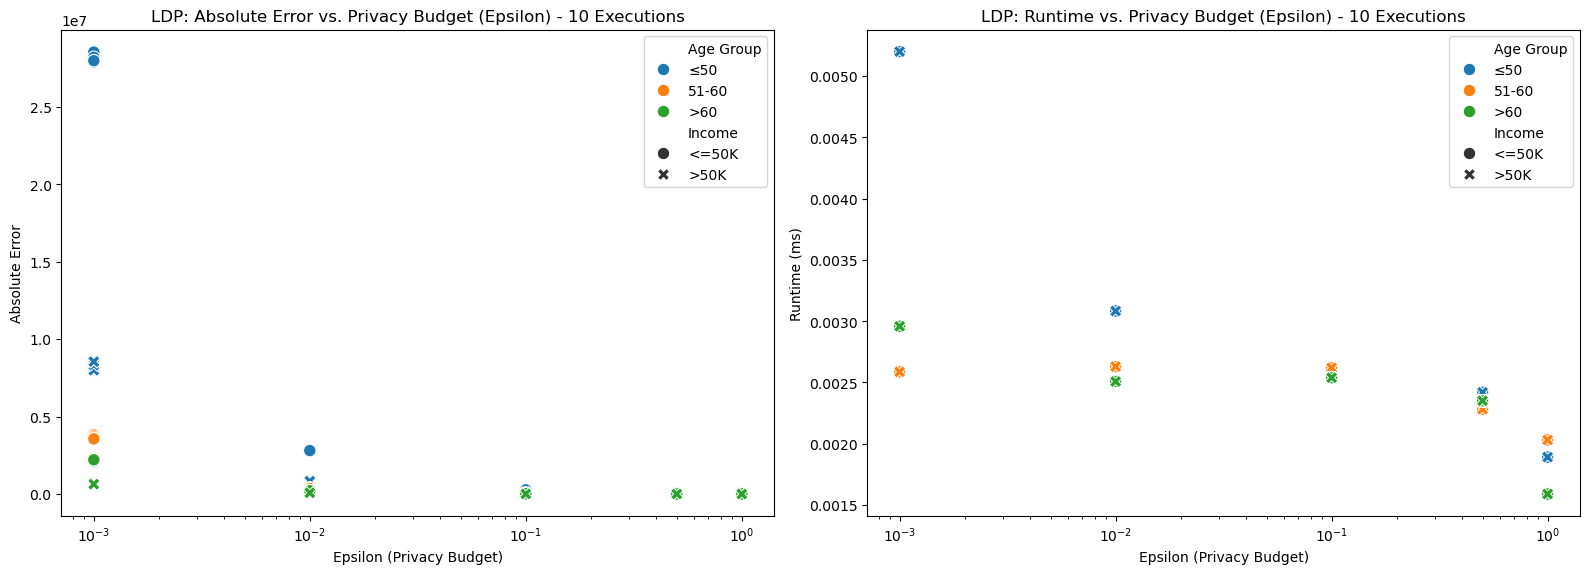

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Define epsilon values for Local Differential Privacy
epsilon_values = [0.001, 0.01, 0.1, 0.5, 1.0]
num_executions = 10

# Randomized Response mechanism for Local Differential Privacy
def randomized_response(value, epsilon, domain=["<=50K", ">50K"]):
    # Calculate probability of keeping true value
    p = np.exp(epsilon) / (1 + np.exp(epsilon))
    
    # With probability p, keep the true value
    # With probability 1-p, sample uniformly from domain
    if np.random.random() < p:
        return value
    else:
        return np.random.choice(domain)

# Measure runtime
def measure_runtime(func, value, epsilon, domain, num_iterations=100):
    start_time = time.time()
    for _ in range(num_iterations):
        func(value, epsilon, domain)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Calculate results
results = []
np.random.seed(42)
age_groups = ["≤50", "51-60", ">60"]
income_categories = ["<=50K", ">50K"]

for age_group in age_groups:
    # Get subset of data for this age group
    subset = combined_df[combined_df['age_group'] == age_group]
    total_records = len(subset)
    
    for epsilon in epsilon_values:
        # Get runtime measurement
        sample_income = income_categories[0]
        runtime = measure_runtime(randomized_response, sample_income, epsilon, income_categories)
        
        for execution in range(num_executions):
            # Apply randomized response to each individual
            privatized_incomes = []
            for _, row in subset.iterrows():
                privatized_income = randomized_response(row['income'], epsilon, income_categories)
                privatized_incomes.append(privatized_income)
            
            for income in income_categories:
                # Get true count for this income category in this age group
                true_count = len(subset[subset['income'] == income])
                
                # Count of privatized responses for this income category
                privatized_count = privatized_incomes.count(income)
                
                # Calculate corrected estimate using the formula for binary randomized response
                p = np.exp(epsilon) / (1 + np.exp(epsilon))
                corrected_estimate = (privatized_count - total_records*(1-p)/2) / (2*p - 1)
                corrected_estimate = int(round(corrected_estimate))
                corrected_estimate = max(0, corrected_estimate)  # Ensure non-negative
                
                # Calculate error
                abs_error = abs(true_count - corrected_estimate)
                
                # Add to results
                results.append({
                    'Age Group': age_group,
                    'Epsilon': epsilon,
                    'Income': income,
                    'True Count': true_count,
                    'Corrected Estimate': corrected_estimate,
                    'Absolute Error': abs_error,
                    'Runtime (ms)': round(runtime, 6),
                    'Execution': execution + 1
                })

# Create DataFrame
ldp_results_df = pd.DataFrame(results)

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error scatter plot
sns.scatterplot(x='Epsilon', y='Absolute Error', hue='Age Group', style='Income', 
                data=ldp_results_df, s=80, ax=ax1)
ax1.set_title('LDP: Absolute Error vs. Privacy Budget (Epsilon) - 10 Executions')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')

# Plot 2: Runtime scatter plot
sns.scatterplot(x='Epsilon', y='Runtime (ms)', hue='Age Group', style='Income', 
                data=ldp_results_df, s=80, ax=ax2)
ax2.set_title('LDP: Runtime vs. Privacy Budget (Epsilon) - 10 Executions')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()